In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from pygam import LinearGAM, f, s, te

Preprocessing and helper functions

In [6]:
# data load
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)

print(mstl_data['city'].unique())
# extrahiere benötigte Spalten für GAMS
residual_data = mstl_data[['timestamp',
                           'city',
                           'counter_site',
                           'seasonal_8766',
                           'residual']].copy()
# filtert Zeilen raus, in denen anstatt Werten die Columnnames stehen
residual_data = residual_data[residual_data['timestamp'] != 'timestamp']
residual_data['res_8766'] = residual_data["seasonal_8766"].astype(float) + residual_data["residual"].astype(float)
residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()
len(list(set(residual_data['id'].to_list())))
# merge with weather data by city and date (in weather data) and timestamp (in residual data)
merged_data = pd.merge(residual_data, weather_data, left_on=['city', residual_data['timestamp']],
                       right_on=['city', weather_data['date']], how='left')
# Referenzzeitpunkt (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist()))
print(ref)

# 1) Spalte vektorisiert in Datetime konvertieren (einmalig)
t_0 = pd.to_datetime(merged_data['timestamp'], utc=True, errors='coerce')

# 2) Differenz in Stunden berechnen (vektorisiert)
merged_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0


def logdiff_to_percent(delta):
    return (np.exp(delta) - 1.0) * 100


def defineX_y(city_data, forecast=False, full=False):
    y = city_data['res_8766'].astype(float).values

    if forecast:
        X = city_data[['timestamp_number', 'id',
                       'forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float).copy()
        X.columns = ['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']

        # Keep only rows where forecast values exist and y exists
        mask = ~X[['temperature_2m', 'rain', 'snowfall']].isna().any(axis=1) & ~np.isnan(y)
        X = X[mask]
        y = y[mask]

    else:  # Use actual data
        X = city_data[['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']].astype(float).copy()

        if full:
            # Keep all rows where actual values exist
            mask = ~X.isna().any(axis=1) & ~np.isnan(y)
            X = X[mask]
            y = y[mask]
        else:
            # Keep only rows where forecast exists (to align lengths)
            X_forecast = city_data[['forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float)
            mask = ~X_forecast.isna().any(axis=1) & ~X.isna().any(axis=1) & ~np.isnan(y)
            X = X[mask]
            y = y[mask]

    return X.values, y


def trainGAM(X, y):
    gam = LinearGAM(
        s(0, n_splines=10, lam=1) +  # timestamp_number (drift)
        f(1, lam=50) +  # id
        s(2, n_splines=6) +  # temp
        s(3, n_splines=5, lam=2) +  # rain
        s(4, n_splines=5, lam=2) +  # snow
        te(2, 3, n_splines=4, lam=2)  # temp × rain
    ).fit(X, y)
    return gam

['Landeshauptstadt Stuttgart' 'city' 'Stadt Freiburg' 'Stadt Heidelberg'
 'Stadt Ludwigsburg' 'Stadt Mannheim' 'Stadt Reutlingen' 'Stadt Tübingen']
2012-12-31 23:00:00+00:00


Train gams and save data

In [7]:
city_models = {"actual": {}, "predicted": {}}
for city in merged_data["city"].unique():
    city_data = merged_data[merged_data["city"] == city]
    X_act, y_act = defineX_y(city_data, forecast=False, full=False)
    gam_act = trainGAM(X_act, y_act)
    city_models["actual"][city] = {
        "gam": gam_act,
        "X": X_act,
        "y": y_act
    }
    X_pred, y_pred = defineX_y(city_data, forecast=True, full=False)
    gam_pred = trainGAM(X_pred, y_pred)
    city_models["predicted"][city] = {
        "gam": gam_pred,
        "X": X_pred,
        "y": y_pred,
    }

Compute temperature and rain curves and histogram data + save

In [8]:
from utils.gam_result_utils import save_temp_effect_results, save_rain_effect_results

# Expected structure of city_models:## city_models = {
#     "actual": {
#         "<city_name>": {
#             "gam": <trained GAM model>,
#             "X": np.ndarray of shape (n_samples, n_features),
#             "y": np.ndarray of shape (n_samples,)   # optional for plotting
#         },
#         ...
#     },
#     "predicted": {
#         "<city_name>": {
#             "gam": <trained GAM model>,
#             "X": np.ndarray of shape (n_samples, n_features),
#             "y": np.ndarray of shape (n_samples,)
# optional for plotting
#         },
#         ...
#     }
# }
save_temp_effect_results(city_models, out_path="../data/temp_effect_results.pkl", temp_col=2, rain_col=3, snow_col=4)
save_rain_effect_results(city_models, out_path="../data/rain_effect_results.pkl")

Saved temperature effect results to ../data/temp_effect_results.pkl
Saved rain effect results to ../data/rain_effect_results.pkl


Function for plotting the temperature effect

In [14]:
import pickle
import numpy as np
from matplotlib.colors import to_rgba


def plot_temp_effect_from_file(path):
    with open(path, "rb") as f:
        results = pickle.load(f)
    actual = results["actual"]
    predicted = results["predicted"]
    hist = results["hist"]
    temps = actual["temps"]
    mean_temp = actual["global_mean_temp"]
    curves_actual = actual["curves"]
    curves_pred = predicted["curves"]
    bins = hist["bins"]
    frac_actual = hist["frac_actual"]
    frac_pred = hist["frac_pred"]
    rain_levels = results["meta"]["rain_levels"]

    # ---- Plot ----
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax2.patch.set_alpha(0)
    width = bins[1] - bins[0]
    h_actual = ax2.bar(bins[:-1], frac_actual, width=width, color="#f4d0c0", alpha=0.5, align="edge", zorder=1)
    h_pred = ax2.bar(bins[:-1], frac_pred, width=width, color="#c0d4f4", alpha=0.5, align="edge", zorder=1)
    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max()) * 1.1)
    actual_colors = ["#08519c", "#e67300", "#2a7f24"]
    pred_colors = ["#4a90d9", "#fdae61", "#66c266"]
    for r, c_act, c_pred in zip(rain_levels, actual_colors, pred_colors):
        ax1.fill_between(
            temps,
            curves_actual[r]["low"],
            curves_actual[r]["high"],
            color=to_rgba(c_act, 0.40),
            zorder=2
        )
        ax1.plot(
            temps,
            curves_actual[r]["mean"],
            lw=2.5,
            color=c_act,
            label=f"Rain={r} mm (actual)",
            zorder=3,
        )
        ax1.fill_between(
            temps,
            curves_pred[r]["low"],
            curves_pred[r]["high"],
            color=to_rgba(c_pred, 0.40),
            zorder=2.5,
        )
        ax1.plot(
            temps,
            curves_pred[r]["mean"],
            lw=2.5,
            color=c_pred,
            label=f"Rain={r} mm (pred)",
            zorder=4,
        )
    ax1.axvline(
        mean_temp,
        color="red",
        lw=2, ls="--",
        label=f"Global mean temp ≈ {mean_temp:.1f}°C",
        zorder=4,
    )
    ax1.axhline(0, color="black", lw=1, zorder=4)
    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Bike count change relative to mean temp (%)")
    ax1.set_title("Temperature effect: actual vs predicted weather")
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(
        handles1 + [h_actual, h_pred],
        labels1 + ["Actual temp", "Predicted temp"],
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

Plot temperature effect

(0, 1.0, 3.0)


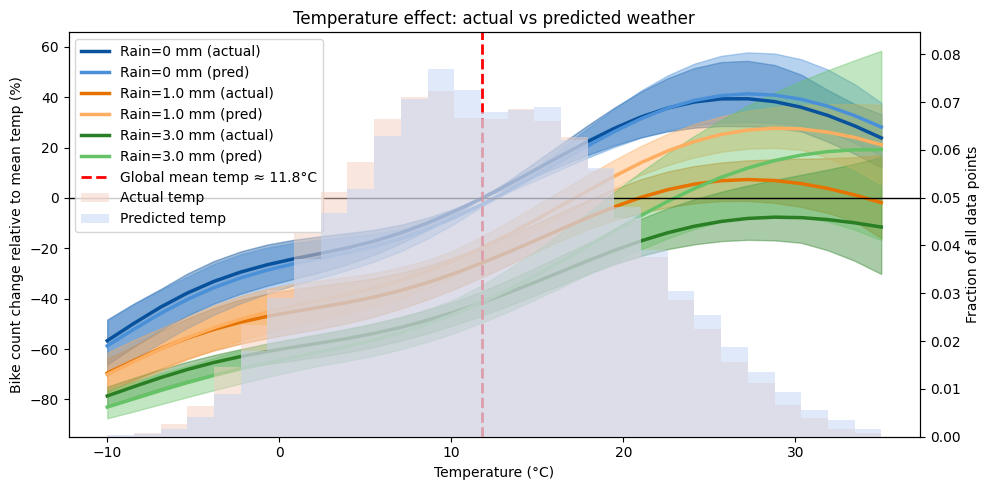

In [15]:
plot_temp_effect_from_file("../data/temp_effect_results.pkl")

Function for plotting the rain curve

In [21]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

def plot_rain_effect_from_file(path):
    # -------------------------------------------------
    # Load results
    # -------------------------------------------------
    with open(path, "rb") as f:
        results = pickle.load(f)
    rain_grid = results["actual"]["rain_grid"]
    summary_actual = results["actual"]["curves"]
    summary_pred   = results["predicted"]["curves"]
    bins = results["hist"]["bins"]
    frac_actual = results["hist"]["frac_actual"]
    frac_pred   = results["hist"]["frac_pred"]
    temps_fixed = results["meta"]["temps_fixed"]
    # -------------------------------------------------
    # Plot setup
    # -------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    actual_colors = ["#08519c", "#e67300", "#2a7f24"]# blue, orange, green
    pred_colors   = ["#4a90d9", "#fdae61", "#66c266"]  # lighter variants
    # -------------------------------------------------
    # Rain effect curves with CIs
    # -------------------------------------------------
    for T, c_actual, c_pred in zip(temps_fixed, actual_colors, pred_colors):
        # Actual
        ax1.fill_between(
            rain_grid,
            summary_actual[T]["low"],
            summary_actual[T]["high"],
            color=to_rgba(c_actual, 0.40),
            zorder=2,
        )
        ax1.plot(
            rain_grid,
            summary_actual[T]["mean"],
            lw=2.5,
            color=c_actual,
            label=f"T={T}°C (actual)",
            zorder=3,
        )
        # Predicted
        ax1.fill_between(
            rain_grid,
            summary_pred[T]["low"],
            summary_pred[T]["high"],
            color=to_rgba(c_pred, 0.40),
            zorder=2.5,
        )
        ax1.plot(
            rain_grid,
            summary_pred[T]["mean"],
            lw=2,
            color=c_pred,
            label=f"T={T}°C (pred)",
            zorder=4,
        )
    # -------------------------------------------------
    # Histogram (fractions)
    # -------------------------------------------------
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    width = bins[1] - bins[0]
    h_actual = ax2.bar(
            bin_centers,
            frac_actual,
            width=width,
            color="lightgray",
            alpha=0.3,
            align="center",
            label="Actual rain",
            zorder=1,
    )
    h_pred = ax2.bar(
            bin_centers,
            frac_pred,
            width=width,
            color="lightblue",
            alpha=0.3,
            align="center",
            label="Predicted rain",
            zorder=1,
    )
    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max()) * 1.1)
    # -------------------------------------------------
    # Labels, legend, layout
    # -------------------------------------------------
    ax1.set_xlabel("Rain (mm)")
    ax1.set_ylabel("Bike count change relative to 0 mm rain (%)")
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
            handles1 + handles2,
            labels1 + labels2,
            loc="upper left",
    )
    ax1.set_title("Marginal effect of rain on bike counts\nActual vs Predicted Weather")
    plt.tight_layout()
    plt.show()

Plot rain effect

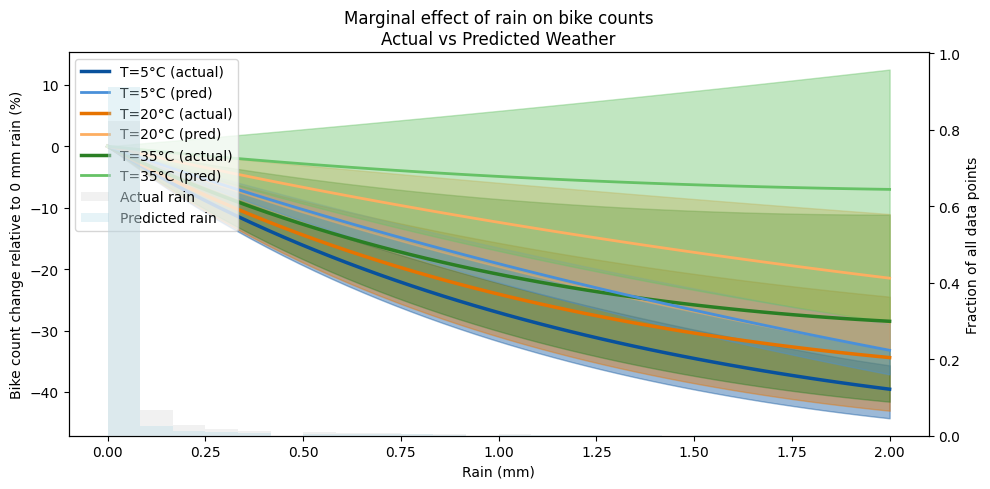

In [19]:
plot_rain_effect_from_file("../data/rain_effect_results.pkl")

In [16]:
def clean_and_join(strings):
    # Strip leading/trailing " and \n from each string, then join them
    cleaned = [s.strip('"\n') for s in strings]
    return ''.join(cleaned)  # You can use ' '.join(cleaned) if you want spaces


# Example usage
texts = ["import pickle\n",
    "import matplotlib.pyplot as plt\n",
    "from matplotlib.colors import to_rgba\n",
    "\n",
    "\n",
    "def plot_rain_effect_from_file(path):\n",
    "    # -------------------------------------------------\n",
    "    # Load results\n",
    "    # -------------------------------------------------\n",
    "    with open(path, \"rb\") as f:\n",
    "        results = pickle.load(f)\n",
    "\n",
    "    rain_grid = results[\"actual\"][\"rain_grid\"]\n",
    "    summary_actual = results[\"actual\"][\"curves\"]\n",
    "    summary_pred   = results[\"predicted\"][\"curves\"]\n",
    "\n",
    "    bins = results[\"hist\"][\"bins\"]\n",
    "    frac_actual = results[\"hist\"][\"frac_actual\"]\n",
    "    frac_pred   = results[\"hist\"][\"frac_pred\"]\n",
    "\n",
    "    temps_fixed = results[\"meta\"][\"temps_fixed\"]\n",
    "\n",
    "    # -------------------------------------------------\n",
    "    # Plot setup\n",
    "    # -------------------------------------------------\n",
    "    fig, ax1 = plt.subplots(figsize=(10, 5))\n",
    "    ax2 = ax1.twinx()\n",
    "\n",
    "    actual_colors = [\"#08519c\", \"#e67300\", \"#2a7f24\"]  # blue, orange, green\n",
    "    pred_colors   = [\"#4a90d9\", \"#fdae61\", \"#66c266\"]  # lighter variants\n",
    "\n",
    "    # -------------------------------------------------\n",
    "    # Rain effect curves with CIs\n",
    "    # -------------------------------------------------\n",
    "    for T, c_actual, c_pred in zip(temps_fixed, actual_colors, pred_colors):\n",
    "        # Actual\n",
    "        ax1.fill_between(\n",
    "            rain_grid,\n",
    "            summary_actual[T][\"low\"],\n",
    "            summary_actual[T][\"high\"],\n",
    "            color=to_rgba(c_actual, 0.40),\n",
    "            zorder=2,\n",
    "        )\n",
    "        ax1.plot(\n",
    "            rain_grid,\n",
    "            summary_actual[T][\"mean\"],\n",
    "            lw=2.5,\n",
    "            color=c_actual,\n",
    "            label=f\"T={T}°C (actual)\",\n",
    "            zorder=3,\n",
    "        )\n",
    "\n",
    "        # Predicted\n",
    "        ax1.fill_between(\n",
    "            rain_grid,\n",
    "            summary_pred[T][\"low\"],\n",
    "            summary_pred[T][\"high\"],\n",
    "            color=to_rgba(c_pred, 0.40),\n",
    "            zorder=2.5,\n",
    "        )\n",
    "        ax1.plot(\n",
    "            rain_grid,\n",
    "            summary_pred[T][\"mean\"],\n",
    "            lw=2,\n",
    "            ls=\"--\",\n",
    "            color=c_pred,\n",
    "            label=f\"T={T}°C (pred)\",\n",
    "            zorder=4,\n",
    "        )\n",
    "\n",
    "    # -------------------------------------------------\n",
    "    # Histogram (fractions)\n",
    "    # -------------------------------------------------\n",
    "    bin_centers = 0.5 * (bins[:-1] + bins[1:])\n",
    "    width = bins[1] - bins[0]\n",
    "\n",
    "    h_actual = ax2.bar(\n",
    "        bin_centers,\n",
    "        frac_actual,\n",
    "        width=width,\n",
    "        color=\"lightgray\",\n",
    "        alpha=0.3,\n",
    "        align=\"center\",\n",
    "        label=\"Actual rain\",\n",
    "        zorder=1,\n",
    "    )\n",
    "\n",
    "    h_pred = ax2.bar(\n",
    "        bin_centers,\n",
    "        frac_pred,\n",
    "        width=width,\n",
    "        color=\"lightblue\",\n",
    "        alpha=0.3,\n",
    "        align=\"center\",\n",
    "        label=\"Predicted rain\",\n",
    "        zorder=1,\n",
    "    )\n",
    "\n",
    "    ax2.set_ylabel(\"Fraction of all data points\")\n",
    "    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max()) * 1.1)\n",
    "\n",
    "    # -------------------------------------------------\n",
    "    # Labels, legend, layout\n",
    "    # -------------------------------------------------\n",
    "    ax1.set_xlabel(\"Rain (mm)\")\n",
    "    ax1.set_ylabel(\"Bike count change relative to 0 mm rain (%)\")\n",
    "\n",
    "    handles1, labels1 = ax1.get_legend_handles_labels()\n",
    "    handles2, labels2 = ax2.get_legend_handles_labels()\n",
    "\n",
    "    ax1.legend(\n",
    "        handles1 + handles2,\n",
    "        labels1 + labels2,\n",
    "        loc=\"upper left\",\n",
    "    )\n",
    "\n",
    "    ax1.set_title(\"Marginal effect of rain on bike counts\\nActual vs Predicted Weather\")\n",
    "\n",
    "    plt.tight_layout()\n",
    "    plt.show()\n"]
result = clean_and_join(texts)
print(result)
# Output: Hello, World!Python is funOpenAI


import pickleimport matplotlib.pyplot as pltfrom matplotlib.colors import to_rgbadef plot_rain_effect_from_file(path):    # -------------------------------------------------    # Load results    # -------------------------------------------------    with open(path, "rb") as f:        results = pickle.load(f)    rain_grid = results["actual"]["rain_grid"]    summary_actual = results["actual"]["curves"]    summary_pred   = results["predicted"]["curves"]    bins = results["hist"]["bins"]    frac_actual = results["hist"]["frac_actual"]    frac_pred   = results["hist"]["frac_pred"]    temps_fixed = results["meta"]["temps_fixed"]    # -------------------------------------------------    # Plot setup    # -------------------------------------------------    fig, ax1 = plt.subplots(figsize=(10, 5))    ax2 = ax1.twinx()    actual_colors = ["#08519c", "#e67300", "#2a7f24"]  # blue, orange, green    pred_colors   = ["#4a90d9", "#fdae61", "#66c266"]  # lighter variants    # ------------------------